In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

### Parameters and data directories

In [2]:
# significance cutoff, after FDR correction
SIG_ALPHA = 0.05

# if True, save figures to images directory
SAVE_FIGS = True
images_dir = Path(cfg.images_dirs['survival'])

# set results directories
# TODO: why do these need to be different?
me_pancancer_results_dir = Path(cfg.results_dirs['survival'], 'me_baseline_alphas')
all_pancancer_results_dir = Path(cfg.results_dirs['survival'], 'all_baseline_alphas')

me_baseline_results_dir = Path(cfg.results_dirs['survival'], 'me_baseline', 'results_baseline')
all_baseline_results_dir = Path(cfg.results_dirs['survival'], 'all_baseline', 'results_baseline')

me_cancer_type_results_dir = Path(cfg.results_dirs['survival'], 'me_shuffle_cancer_type')
all_cancer_type_results_dir = Path(cfg.results_dirs['survival'], 'all_shuffle_cancer_type')

# set list of PCA component numbers to look for
pcs_list = [10, 100, 500, 1000, 5000]

### Pan-cancer survival prediction, expression vs. methylation

In [3]:
# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
}

In [4]:
# get baseline predictor results, using non-omics covariates only
me_pancancer_df = []

for n_dim in pcs_list:
    # load results into a single dataframe
    me_pcs_dir = Path(me_pancancer_results_dir, 'results_{}_pca'.format(n_dim))
    me_results_df = su.load_survival_results(me_pcs_dir)
    me_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    me_results_df['n_dim'] = n_dim
    me_pancancer_df.append(me_results_df)
    
me_pancancer_df = pd.concat(me_pancancer_df)
me_pancancer_df = (me_pancancer_df
      .loc[me_pancancer_df.cancer_type == 'pancancer', :]
      .reset_index(drop=True)
)
me_pancancer_df.training_data.replace(to_replace=training_data_map, inplace=True)

print(me_pancancer_df.shape)
print(me_pancancer_df.n_dim.unique())
print(me_pancancer_df.training_data.unique())
me_pancancer_df.head()

(720, 8)
[  10  100  500 1000 5000]
['gene expression' '27k methylation' '450k methylation']


,cindex,data_type,cancer_type,training_data,signal,seed,fold,n_dim
0,0.70265,train,pancancer,gene expression,shuffled,1,0,10
1,0.70265,cv,pancancer,gene expression,shuffled,1,0,10
2,0.68260,test,pancancer,gene expression,shuffled,1,0,10
3,0.70239,train,pancancer,gene expression,shuffled,1,1,10
4,0.70239,cv,pancancer,gene expression,shuffled,1,1,10


In [5]:
# get baseline predictor results, using non-omics covariates only
me_baseline_results_dir = Path(cfg.results_dirs['survival'],
                               'me_baseline',
                               'results_baseline')
me_baseline_df = su.load_survival_results(me_baseline_results_dir)
me_baseline_df.rename(columns={'identifier': 'cancer_type',
                               'fold_no': 'fold'}, inplace=True)
print(me_baseline_df.shape)
print(me_baseline_df.training_data.unique())
me_baseline_df.head()

(1512, 7)
['baseline']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.58466,train,THCA,baseline,shuffled,42,0
1,0.58466,cv,THCA,baseline,shuffled,42,0
2,0.61196,test,THCA,baseline,shuffled,42,0
3,0.51766,train,THCA,baseline,shuffled,42,1
4,0.51766,cv,THCA,baseline,shuffled,42,1


8


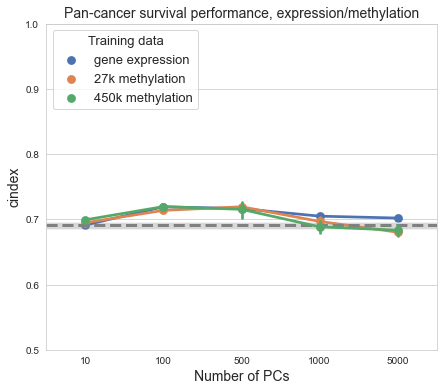

In [6]:
sns.set({'figure.figsize': (7, 6)})
sns.set_style('whitegrid')

sns.pointplot(data=me_pancancer_df,
              x='n_dim', y='cindex', hue='training_data', 
              hue_order=training_data_map.values())
plt.xlabel('Number of PCs', size=14)
plt.ylabel('cindex', size=14)
plt.legend(title='Training data', fontsize=13, title_fontsize=13, loc='upper left')
plt.title('Pan-cancer survival performance, expression/methylation', size=14)
plt.ylim(0.5, 1.0)

# plot baseline mean/bootstrapped 95% CI
baseline_vals = (me_baseline_df
    [(me_baseline_df.data_type == 'test') &
     (me_baseline_df.signal == 'signal') &
     (me_baseline_df.cancer_type == 'pancancer')]
).cindex.values
print(len(baseline_vals))

baseline_mean = np.mean(baseline_vals)
plt.gca().axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

baseline_ci = sns.utils.ci(
    sns.algorithms.bootstrap(baseline_vals,
                             func=np.mean,
                             n_boot=1000,
                             units=None,
                             seed=cfg.default_seed)
)
plt.gca().axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)

if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'me_pancan_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'me_pancan_survival.png',
                dpi=300, bbox_inches='tight')

### Pan-cancer survival prediction, all data types

In [7]:
# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}

In [8]:
# get baseline predictor results, using non-omics covariates only
all_pancancer_df = []

for n_dim in pcs_list:
    # load results into a single dataframe
    all_pcs_dir = Path(all_pancancer_results_dir, 'results_{}_pca'.format(n_dim))
    all_results_df = su.load_survival_results(all_pcs_dir)
    all_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    all_results_df['n_dim'] = n_dim
    all_pancancer_df.append(all_results_df)
    
all_pancancer_df = pd.concat(all_pancancer_df)
all_pancancer_df = (all_pancancer_df
      .loc[all_pancancer_df.cancer_type == 'pancancer', :]
      .reset_index(drop=True)
)
all_pancancer_df.training_data.replace(to_replace=training_data_map, inplace=True)

print(all_pancancer_df.shape)
print(all_pancancer_df.n_dim.unique())
print(all_pancancer_df.training_data.unique())
all_pancancer_df.head()

(1440, 8)
[  10  100  500 1000 5000]
['gene expression' '27k methylation' '450k methylation' 'microRNA' 'RPPA'
 'mutational signatures']


,cindex,data_type,cancer_type,training_data,signal,seed,fold,n_dim
0,0.70935,train,pancancer,gene expression,shuffled,1,0,10
1,0.70935,cv,pancancer,gene expression,shuffled,1,0,10
2,0.70618,test,pancancer,gene expression,shuffled,1,0,10
3,0.70786,train,pancancer,gene expression,shuffled,1,1,10
4,0.70786,cv,pancancer,gene expression,shuffled,1,1,10


In [9]:
# get baseline predictor results, using non-omics covariates only
all_baseline_results_dir = Path(cfg.results_dirs['survival'],
                               'all_baseline',
                               'results_baseline')
all_baseline_df = su.load_survival_results(all_baseline_results_dir)
all_baseline_df.rename(columns={'identifier': 'cancer_type',
                               'fold_no': 'fold'}, inplace=True)
print(all_baseline_df.shape)
print(all_baseline_df.training_data.unique())
all_baseline_df.head()

(1272, 7)
['baseline']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.52001,train,THCA,baseline,shuffled,42,0
1,0.52001,cv,THCA,baseline,shuffled,42,0
2,0.27595,test,THCA,baseline,shuffled,42,0
3,0.61423,train,THCA,baseline,shuffled,42,1
4,0.61423,cv,THCA,baseline,shuffled,42,1


8


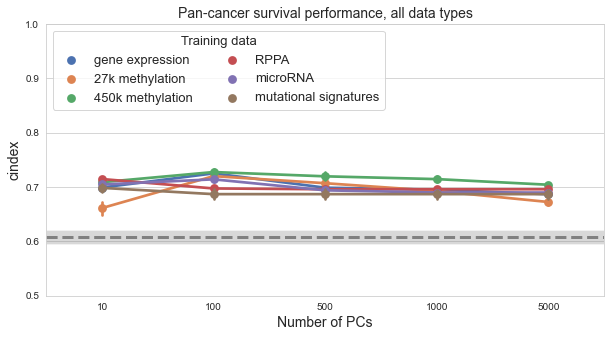

In [10]:
sns.set({'figure.figsize': (10, 5)})
sns.set_style('whitegrid')

sns.pointplot(data=all_pancancer_df,
              x='n_dim', y='cindex', hue='training_data', 
              hue_order=training_data_map.values())
plt.xlabel('Number of PCs', size=14)
plt.ylabel('cindex', size=14)
plt.legend(title='Training data', fontsize=13, title_fontsize=13, loc='upper left', ncol=2)
plt.title('Pan-cancer survival performance, all data types', size=14)
plt.ylim(0.5, 1.0)

# plot baseline mean/bootstrapped 95% CI
baseline_vals = (all_baseline_df
    [(all_baseline_df.data_type == 'test') &
     (all_baseline_df.signal == 'signal') &
     (all_baseline_df.cancer_type == 'pancancer')]
).cindex.values
print(len(baseline_vals))

baseline_mean = np.mean(baseline_vals)
plt.gca().axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

baseline_ci = sns.utils.ci(
    sns.algorithms.bootstrap(baseline_vals,
                             func=np.mean,
                             n_boot=1000,
                             units=None,
                             seed=cfg.default_seed)
)
plt.gca().axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_pancan_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_pancan_survival.png',
                dpi=300, bbox_inches='tight')

### Individual cancer survival prediction, expression vs. methylation

In [11]:
me_data_count_df = []

for n_dim in pcs_list:
    # load results into a single dataframe
    me_pcs_dir = Path(me_cancer_type_results_dir, 'results_{}_pca'.format(n_dim))
    me_results_df = su.load_survival_results(me_pcs_dir)
    me_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    
    me_count_df = (me_results_df[me_results_df.data_type == 'test']
        .groupby(['cancer_type', 'training_data'])
        .count()
    )
    problem_df = me_count_df[me_count_df['cindex'] != 16].copy()
    drop_cancer_types = problem_df.index.get_level_values(0).unique().values
    
    me_all_results_df = au.compare_all_data_types(
        me_results_df[~me_results_df.cancer_type.isin(drop_cancer_types)],
        SIG_ALPHA,
        identifier='cancer_type',
        metric='cindex')
    
    print(n_dim)
    num_reject = me_all_results_df.groupby(['training_data']).sum().reject_null
    num_total = me_all_results_df.groupby(['training_data']).count().reject_null
    
    dim_count_df = (
            pd.DataFrame(num_reject).rename(columns={'reject_null': 'num_reject'})
        .merge(
            pd.DataFrame(num_total).rename(columns={'reject_null': 'num_total'})
        , left_index=True, right_index=True)
    )
    dim_count_df['n_dim'] = n_dim
    dim_count_df['ratio'] = dim_count_df.num_reject / dim_count_df.num_total
    me_data_count_df.append(dim_count_df)
    
me_data_count_df = pd.concat(me_data_count_df).reset_index()
me_data_count_df.training_data.replace(to_replace=training_data_map, inplace=True)
me_data_count_df.head(10)

10
100
500
1000
5000


,training_data,num_reject,num_total,n_dim,ratio
0,gene expression,12,30,10,0.400000
1,27k methylation,5,30,10,0.166667
2,450k methylation,6,30,10,0.200000
3,gene expression,11,28,100,0.392857
4,27k methylation,7,28,100,0.250000
5,450k methylation,10,28,100,0.357143
6,gene expression,13,29,500,0.448276
7,27k methylation,6,29,500,0.206897
8,450k methylation,10,29,500,0.344828
9,gene expression,11,27,1000,0.407407


Text(0.5, 1.0, 'Well-predicted/total ratio vs. PC count')

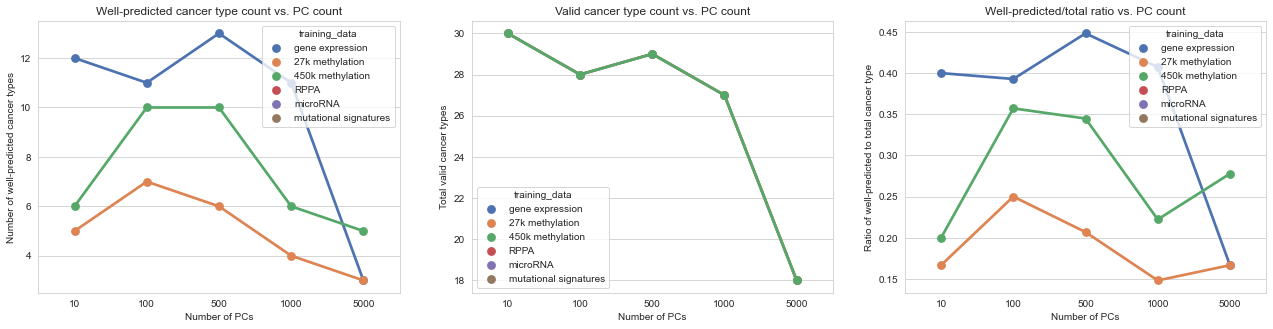

In [12]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

sns.pointplot(data=me_data_count_df, x='n_dim', y='num_reject',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[0])
axarr[0].set_xlabel('Number of PCs')
axarr[0].set_ylabel('Number of well-predicted cancer types')
axarr[0].set_title('Well-predicted cancer type count vs. PC count')

sns.pointplot(data=me_data_count_df, x='n_dim', y='num_total',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[1])
axarr[1].set_xlabel('Number of PCs')
axarr[1].set_ylabel('Total valid cancer types')
axarr[1].set_title('Valid cancer type count vs. PC count')

sns.pointplot(data=me_data_count_df, x='n_dim', y='ratio',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[2])
axarr[2].set_xlabel('Number of PCs')
axarr[2].set_ylabel('Ratio of well-predicted to total cancer type')
axarr[2].set_title('Well-predicted/total ratio vs. PC count')

In [13]:
me_performance_df = []
all_drop_cancer_types = set()

for n_dim in pcs_list:
    # load results into a single dataframe
    me_pcs_dir = Path(me_cancer_type_results_dir, 'results_{}_pca'.format(n_dim))
    me_results_df = su.load_survival_results(me_pcs_dir)
    me_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    
    me_count_df = (me_results_df[me_results_df.data_type == 'test']
        .groupby(['cancer_type', 'training_data'])
        .count()
    )
    problem_df = me_count_df[me_count_df['cindex'] != 16].copy()
    drop_cancer_types = problem_df.index.get_level_values(0).unique().values
    
    me_all_results_df = me_results_df[
        (me_results_df.data_type == 'test') &
        (me_results_df.signal == 'signal')
    ].copy()
    me_all_results_df.drop(columns=['data_type', 'signal'], inplace=True)
    
    me_all_results_df['n_dim'] = n_dim
    me_performance_df.append(me_all_results_df)
      
me_performance_df = pd.concat(me_performance_df)
me_performance_df.training_data.replace(to_replace=training_data_map, inplace=True)
me_performance_df.head(10)

,cindex,cancer_type,training_data,seed,fold,n_dim
2,0.27481,PCPG,gene expression,1,0,10
5,0.44737,PCPG,gene expression,1,1,10
8,0.45283,PCPG,gene expression,1,2,10
11,0.50000,PCPG,gene expression,1,3,10
2,0.54230,COAD,27k methylation,1,0,10
5,0.50000,COAD,27k methylation,1,1,10
8,0.51765,COAD,27k methylation,1,2,10
11,0.56381,COAD,27k methylation,1,3,10
2,0.67278,pancancer,gene expression,42,0,10
5,0.67866,pancancer,gene expression,42,1,10


In [14]:
group_cancer_types = me_performance_df.groupby(['cancer_type']).count().n_dim
max_count = group_cancer_types.max()
valid_cancer_types = group_cancer_types[group_cancer_types == max_count].index
print(valid_cancer_types)

Index(['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'ESCA', 'GBM', 'HNSC',
       'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'PAAD',
       'PRAD', 'SARC', 'SKCM', 'STAD', 'THCA', 'UCEC', 'UVM', 'pancancer'],
      dtype='object', name='cancer_type')


Text(0.5, 1.0, 'Performance for varying PC count, averaged over cancer types')

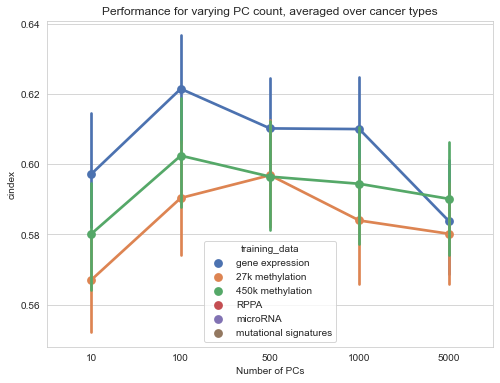

In [15]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.pointplot(data=me_performance_df, x='n_dim', y='cindex', hue='training_data',
              hue_order=training_data_map.values())
plt.xlabel('Number of PCs')
plt.ylabel('cindex')
plt.title('Performance for varying PC count, averaged over cancer types')

In [16]:
cancer_type_avg = (
    me_performance_df[me_performance_df.cancer_type.isin(valid_cancer_types)]
      .groupby('cancer_type')
      .mean()
).cindex
cancer_type_avg.sort_values(ascending=False).head(10)

cancer_type
ACC          0.774280
KIRP         0.761727
UVM          0.739057
LGG          0.695757
KIRC         0.694210
pancancer    0.687135
MESO         0.675858
SARC         0.658723
PRAD         0.615306
UCEC         0.610651
Name: cindex, dtype: float64

In [17]:
cancer_type_sd = me_performance_df.groupby('cancer_type').std().cindex
cancer_type_cv = cancer_type_avg / cancer_type_sd
cancer_type_cv.sort_values(ascending=False).head(10)

cancer_type
pancancer    24.085411
LUSC         13.067526
LGG          12.963817
HNSC         12.755004
STAD         12.464479
SKCM         10.701246
BLCA         10.578933
KIRC         10.198538
LUAD          9.393649
MESO          9.277099
Name: cindex, dtype: float64

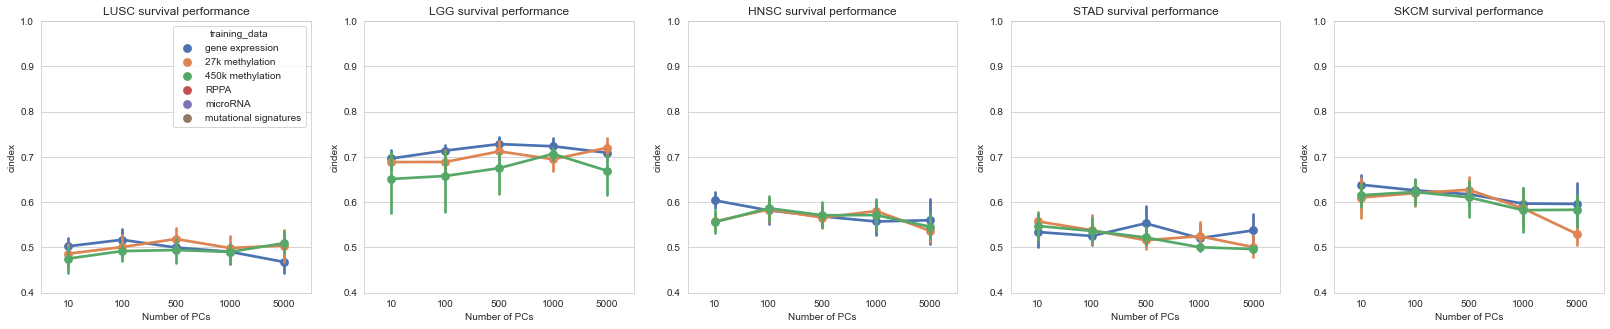

In [18]:
sns.set({'figure.figsize': (28, 5)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 5)

cancer_type_cv = cancer_type_cv[cancer_type_cv.index != 'pancancer']
for ix, cancer_type in enumerate(cancer_type_cv.sort_values(ascending=False).index[:5]):
    ax = axarr[ix]
    sns.pointplot(data=me_performance_df[me_performance_df.cancer_type == cancer_type],
                  x='n_dim', y='cindex', hue='training_data',
                  hue_order=training_data_map.values(), ax=ax)
    ax.set_xlabel('Number of PCs')
    ax.set_ylabel('cindex')
    ax.set_title('{} survival performance'.format(cancer_type))
    ax.set_ylim(0.4, 1.0)
    if ix != 0:
        ax.get_legend().remove()
        
if SAVE_FIGS:
    plt.savefig(images_dir / 'me_top_cancers_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'me_top_cancers_survival.png',
                dpi=300, bbox_inches='tight')

### Individual cancer survival prediction, all data types

In [19]:
all_data_count_df = []

for n_dim in pcs_list:
    # load results into a single dataframe
    all_pcs_dir = Path(all_cancer_type_results_dir, 'results_{}_pca'.format(n_dim))
    all_results_df = su.load_survival_results(all_pcs_dir)
    all_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    
    all_count_df = (all_results_df[all_results_df.data_type == 'test']
        .groupby(['cancer_type', 'training_data'])
        .count()
    )
    problem_df = all_count_df[all_count_df['cindex'] != 16].copy()
    drop_cancer_types = problem_df.index.get_level_values(0).unique().values
    
    all_all_results_df = au.compare_all_data_types(
        all_results_df[~all_results_df.cancer_type.isin(drop_cancer_types)],
        SIG_ALPHA,
        identifier='cancer_type',
        metric='cindex')
    
    print(n_dim)
    num_reject = all_all_results_df.groupby(['training_data']).sum().reject_null
    num_total = all_all_results_df.groupby(['training_data']).count().reject_null
    
    dim_count_df = (
            pd.DataFrame(num_reject).rename(columns={'reject_null': 'num_reject'})
        .merge(
            pd.DataFrame(num_total).rename(columns={'reject_null': 'num_total'})
        , left_index=True, right_index=True)
    )
    dim_count_df['n_dim'] = n_dim
    dim_count_df['ratio'] = dim_count_df.num_reject / dim_count_df.num_total
    all_data_count_df.append(dim_count_df)
    
all_data_count_df = pd.concat(all_data_count_df).reset_index()
all_data_count_df.training_data.replace(to_replace=training_data_map, inplace=True)
all_data_count_df.head(10)

10
100
500
1000
5000


,training_data,num_reject,num_total,n_dim,ratio
0,gene expression,7,24,10,0.291667
1,27k methylation,3,24,10,0.125000
2,450k methylation,6,24,10,0.250000
3,microRNA,3,24,10,0.125000
4,mutational signatures,1,24,10,0.041667
5,RPPA,3,24,10,0.125000
6,gene expression,7,23,100,0.304348
7,27k methylation,3,23,100,0.130435
8,450k methylation,4,23,100,0.173913
9,microRNA,7,23,100,0.304348


Text(0.5, 1.0, 'Well-predicted/total ratio vs. PC count')

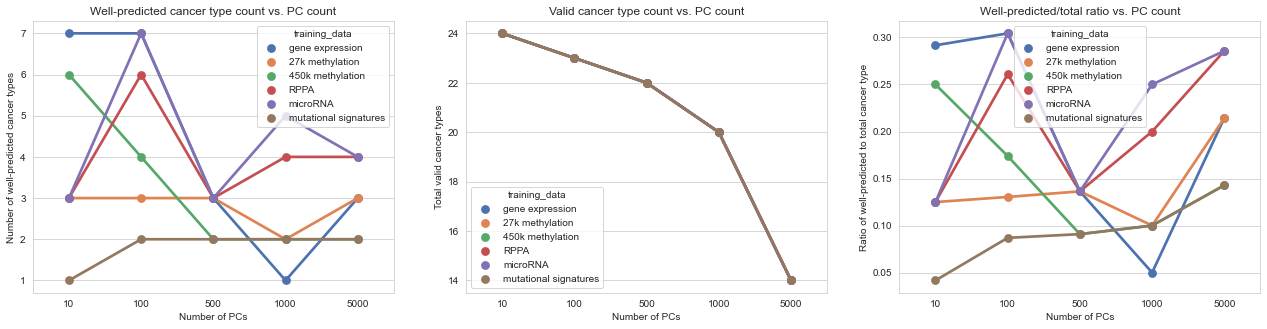

In [20]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

sns.pointplot(data=all_data_count_df, x='n_dim', y='num_reject',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[0])
axarr[0].set_xlabel('Number of PCs')
axarr[0].set_ylabel('Number of well-predicted cancer types')
axarr[0].set_title('Well-predicted cancer type count vs. PC count')

sns.pointplot(data=all_data_count_df, x='n_dim', y='num_total',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[1])
axarr[1].set_xlabel('Number of PCs')
axarr[1].set_ylabel('Total valid cancer types')
axarr[1].set_title('Valid cancer type count vs. PC count')

sns.pointplot(data=all_data_count_df, x='n_dim', y='ratio',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[2])
axarr[2].set_xlabel('Number of PCs')
axarr[2].set_ylabel('Ratio of well-predicted to total cancer type')
axarr[2].set_title('Well-predicted/total ratio vs. PC count')

In [21]:
all_performance_df = []
all_drop_cancer_types = set()

for n_dim in pcs_list:
    # load results into a single dataframe
    all_pcs_dir = Path(all_cancer_type_results_dir, 'results_{}_pca'.format(n_dim))
    all_results_df = su.load_survival_results(all_pcs_dir)
    all_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    
    all_count_df = (all_results_df[all_results_df.data_type == 'test']
        .groupby(['cancer_type', 'training_data'])
        .count()
    )
    problem_df = all_count_df[all_count_df['cindex'] != 16].copy()
    drop_cancer_types = problem_df.index.get_level_values(0).unique().values
    
    all_all_results_df = all_results_df[
        (all_results_df.data_type == 'test') &
        (all_results_df.signal == 'signal')
    ].copy()
    all_all_results_df.drop(columns=['data_type', 'signal'], inplace=True)
    
    all_all_results_df['n_dim'] = n_dim
    all_performance_df.append(all_all_results_df)
    
all_performance_df = pd.concat(all_performance_df)
all_performance_df.training_data.replace(to_replace=training_data_map, inplace=True)
all_performance_df.head(10)

,cindex,cancer_type,training_data,seed,fold,n_dim
2,0.70337,LGG,RPPA,1,0,10
5,0.63396,LGG,RPPA,1,1,10
8,0.69879,LGG,RPPA,1,2,10
11,0.68169,LGG,RPPA,1,3,10
2,0.50000,UCS,RPPA,42,0,10
5,0.62295,UCS,RPPA,42,1,10
8,0.64444,UCS,RPPA,42,2,10
11,0.71053,UCS,RPPA,42,3,10
2,0.63559,PRAD,RPPA,1,0,10
5,0.53949,PRAD,RPPA,1,1,10


In [22]:
group_cancer_types = all_performance_df.groupby(['cancer_type']).count().n_dim
max_count = group_cancer_types.max()
valid_cancer_types = group_cancer_types[group_cancer_types == max_count].index
print(valid_cancer_types)

Index(['ACC', 'BLCA', 'BRCA', 'CHOL', 'COAD', 'HNSC', 'KIRC', 'KIRP', 'LGG',
       'LIHC', 'LUAD', 'LUSC', 'MESO', 'PAAD', 'SARC', 'SKCM', 'STAD', 'TGCT',
       'THCA', 'UCEC', 'UCS', 'pancancer'],
      dtype='object', name='cancer_type')


Text(0.5, 1.0, 'Performance for varying PC count, averaged over cancer types')

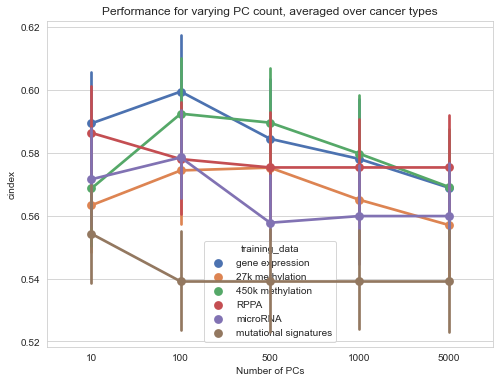

In [23]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.pointplot(data=all_performance_df, x='n_dim', y='cindex', hue='training_data',
              hue_order=training_data_map.values())
plt.xlabel('Number of PCs')
plt.ylabel('cindex')
plt.title('Performance for varying PC count, averaged over cancer types')

In [24]:
cancer_type_avg = (
    all_performance_df[all_performance_df.cancer_type.isin(valid_cancer_types)]
      .groupby('cancer_type')
      .mean()
).cindex
cancer_type_avg.sort_values(ascending=False).head(10)

cancer_type
ACC          0.725109
KIRP         0.718587
LGG          0.691424
pancancer    0.652626
KIRC         0.639724
UCEC         0.634789
SARC         0.609892
MESO         0.586324
BLCA         0.581912
SKCM         0.579069
Name: cindex, dtype: float64

In [25]:
cancer_type_sd = all_performance_df.groupby('cancer_type').std().cindex
cancer_type_cv = cancer_type_avg / cancer_type_sd
cancer_type_cv.sort_values(ascending=False).head(10)

cancer_type
LGG          14.413307
LUSC         13.065104
pancancer    11.106733
BLCA          9.519124
HNSC          9.128764
STAD          8.848781
PAAD          8.284964
KIRC          7.710469
COAD          7.490682
SKCM          7.155875
Name: cindex, dtype: float64

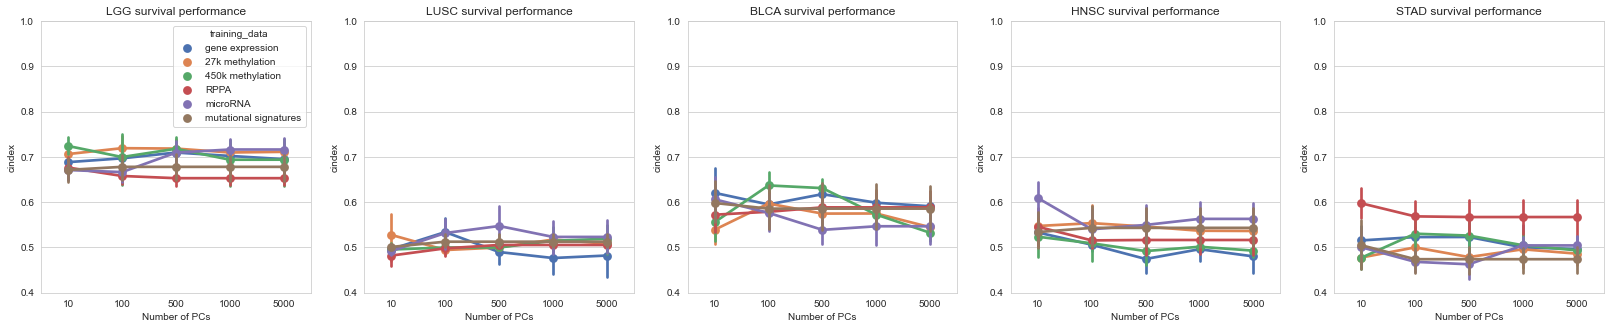

In [27]:
sns.set({'figure.figsize': (28, 5)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 5)

cancer_type_cv = cancer_type_cv[cancer_type_cv.index != 'pancancer']
for ix, cancer_type in enumerate(cancer_type_cv.sort_values(ascending=False).index[:5]):
    ax = axarr[ix]
    sns.pointplot(data=all_performance_df[all_performance_df.cancer_type == cancer_type],
                  x='n_dim', y='cindex', hue='training_data',
                  hue_order=training_data_map.values(), ax=ax)
    ax.set_xlabel('Number of PCs')
    ax.set_ylabel('cindex')
    ax.set_title('{} survival performance'.format(cancer_type))
    ax.set_ylim(0.4, 1.0)
    if ix != 0:
        ax.get_legend().remove()
        
if SAVE_FIGS:
    plt.savefig(images_dir / 'all_top_cancers_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_top_cancers_survival.png',
                dpi=300, bbox_inches='tight')